# SPADE Record Classification Instrument

__Authors/Dates:__

- Paarth Kapadia 2020-11-27
- Justin Mower, PhD approximately 2021-11
- Andrew Zimolzak, MD, MMSc on 2022-01-26

__Description:__ This program trains predictors of missed opputunity of diagnosis (MOD) based on a small number of structured medical record features. The population are selected from emergency department visits, where a rules-based "trigger" shows a possible missed opportunity. Definitive presence/absence of MOD (sometimes called TTP/TFP) in this cohort was determined by expert chart review.

__TODO:__
- Figure out how to access each individual tree in XGBoost model
- Make RF and XGB visualizations consistent with Log visualization
- Clean up printing

## Imports

In [1]:
# data manipulation
import pandas as pd
import numpy as np
import scipy

# visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# machine learning
from sklearn import preprocessing
from sklearn import utils
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFECV, chi2, mutual_info_classif
from xgboost import XGBClassifier

# misc.
import os
import copy
from modules import gendata, cm_metrics
from datetime import datetime, timedelta

In [2]:
# ipython magic
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# matlpotlib properties
plt.rcParams["figure.figsize"] = 6,6
plt.rcParams["figure.dpi"] = 150
plt.rcParams['figure.max_open_warning'] = False
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# seaborn properties
sns.set(style="whitegrid")

## Constants

In [3]:
# set working path 
WORKING_PATH = "./"

In [4]:
# set input directory
INPUT_DIRECTORY_FILEPATH = os.path.join(WORKING_PATH, 'input')

In [5]:
# set output directories
OUTPUT_DIRECTORY_FILEPATHS = {
        'SU': os.path.join(WORKING_PATH, 'output/1 - set up')
        ,'DI': os.path.join(WORKING_PATH, 'output/2 - data input')
        ,'HI': os.path.join(WORKING_PATH, 'output/3 - human input')
        ,'EDA': os.path.join(WORKING_PATH, 'output/4 - exploratory data analysis')
        ,'DP': os.path.join(WORKING_PATH, 'output/5 - data preparation')
        ,'MP': os.path.join(WORKING_PATH, 'output/6 - modeling and prediction')
        ,'ME': os.path.join(WORKING_PATH, 'output/7 - model evaluation')
        ,'MAV': os.path.join(WORKING_PATH, 'output/8 - model analysis and visualization')
    }

# create output directories
for k,v in OUTPUT_DIRECTORY_FILEPATHS.items():
    try:
        os.makedirs(v)  
    except OSError as file_error:  
        print(file_error) 

[WinError 183] Cannot create a file when that file already exists: './output/1 - set up'
[WinError 183] Cannot create a file when that file already exists: './output/2 - data input'
[WinError 183] Cannot create a file when that file already exists: './output/3 - human input'
[WinError 183] Cannot create a file when that file already exists: './output/4 - exploratory data analysis'
[WinError 183] Cannot create a file when that file already exists: './output/5 - data preparation'
[WinError 183] Cannot create a file when that file already exists: './output/6 - modeling and prediction'
[WinError 183] Cannot create a file when that file already exists: './output/7 - model evaluation'
[WinError 183] Cannot create a file when that file already exists: './output/8 - model analysis and visualization'


In [6]:
# seed
RANDOM_STATE_SEED = 42

In [7]:
# train-test-split test size
TEST_SIZE = 0.15

In [8]:
# logistic regression model constants
LOGISTIC_REGRESSION_ITER = 10000

## Input

### Read

In [9]:
# set data sources
USE_ARTIFICIAL_DATA = False
INPUT_FILEPATH = ''

if USE_ARTIFICIAL_DATA:
    INPUT_FILEPATH = os.path.join(INPUT_DIRECTORY_FILEPATH, 'input_artificial.csv')
else:
    INPUT_FILEPATH = os.path.join(INPUT_DIRECTORY_FILEPATH, 'input.csv')

In [10]:
df = pd.read_csv(INPUT_FILEPATH)
df = df.set_index('study_ids')

### Clean

In [11]:
list(df.columns)

['ed_duration',
 'ed_inp_delta',
 'age_val',
 'img_flags',
 'con_flags',
 'smk_flags_man',
 'smk_flags_db',
 'elix_score',
 'mod_label']

In [12]:
df = df.drop('smk_flags_man', axis=1)
df = df.drop('smk_flags_db', axis=1)

In [13]:
# TODO: null_mappings.csv
# currently, there are no columns with nulls; however, if we have any columns in the future where there is a non-NaN
# value use to represent a null (e.g., -1), that non-NaN null value needs to be parsed to an NaN here

In [14]:
# TODO: remappings.csv
# if any values need to be remapped (e.g., MS Access DB values where 2 is no rather than 0), do so here

In [15]:
drops_df = pd.read_csv(os.path.join(INPUT_DIRECTORY_FILEPATH,'drops.csv'))

for d in drops_df.iloc:
    if int(d['axis']) == 0:
        df = df.drop(df[df[d['data']]==d['value']].index, axis=0)
    if int(d['axis']) == 1:
        df = df.drop(d['data'], axis=1)

### Categorize Columns

In [16]:
list(df.columns)

['ed_duration',
 'ed_inp_delta',
 'age_val',
 'img_flags',
 'con_flags',
 'elix_score',
 'mod_label']

In [17]:
label_column = 'mod_label'

In [18]:
feature_columns = copy.copy(list(df.columns))
feature_columns.remove(label_column)

In [19]:
feature_columns_cont = [
    'ed_inp_delta'
    ,'ed_duration'
    ,'elix_score'
    ,'age_val'
]

In [20]:
feature_columns_cat = [
    'img_flags'
    ,'con_flags'
]

## EDA

### Blanks

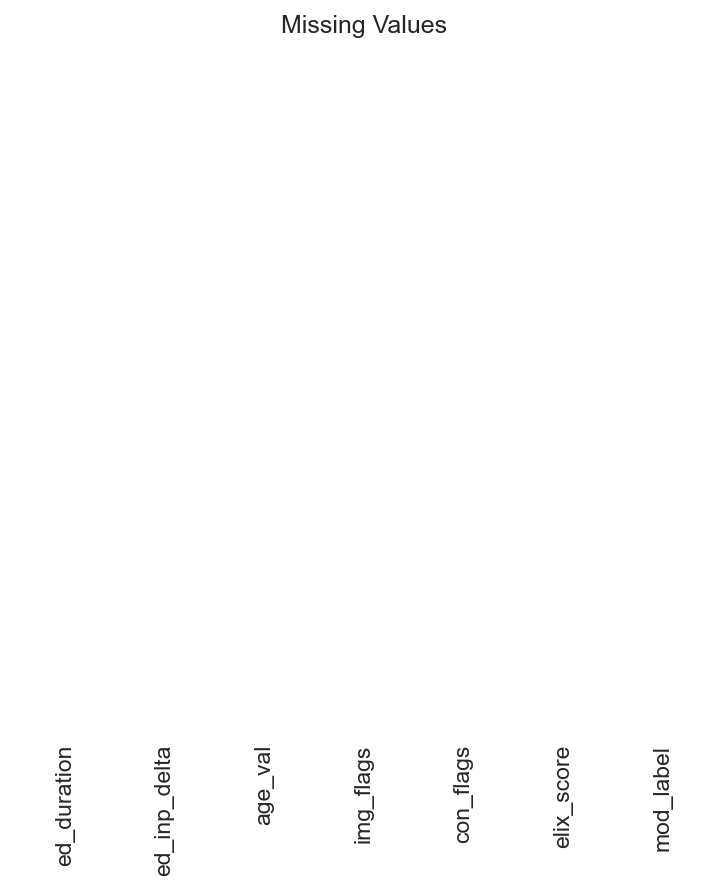

In [21]:
# Create figure variables
blanks_fig, blanks_axes = plt.subplots()
sns.heatmap(df.isnull(), xticklabels=True, yticklabels=False, cmap='binary', cbar=False, ax=blanks_axes)

# Set text
blanks_axes.set_title('Missing Values')
blanks_axes.set_ylabel('')
blanks_axes.set_xlabel('')

# Save figure
blanks_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], 'features_blanks.svg'))

### Features

#### Distribution

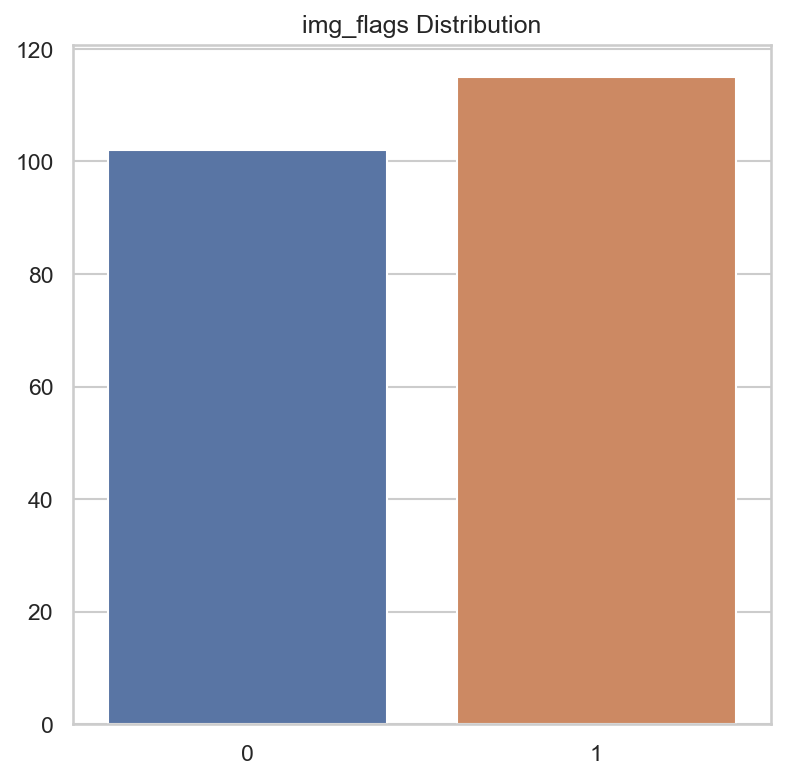

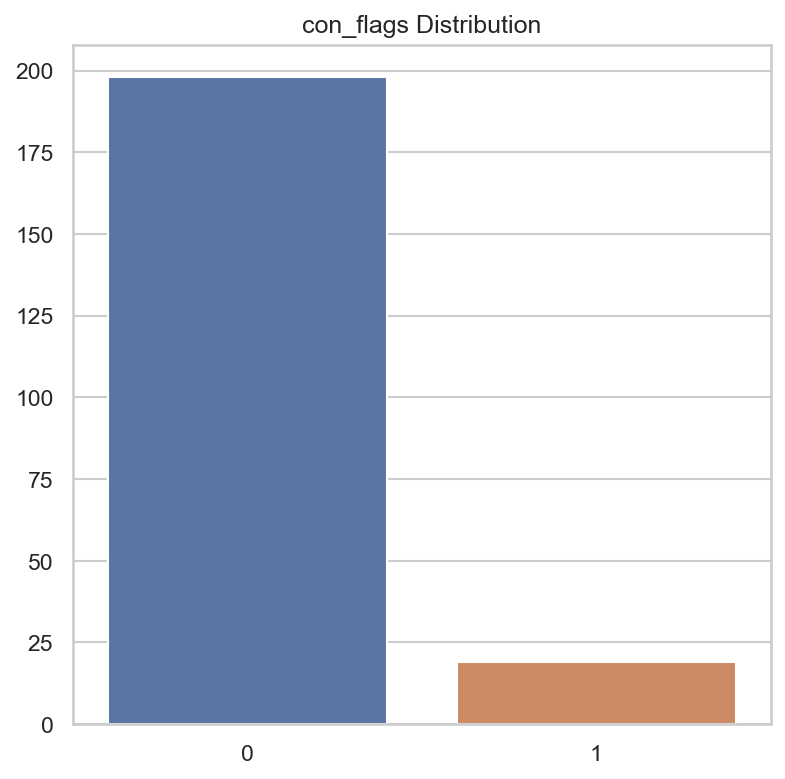

In [22]:
for col in feature_columns_cat:

    # Create figure variables
    fldist_fig, fldist_axes = plt.subplots()
    sns.countplot(data=df, x=col, ax=fldist_axes)

    # Set text
    fldist_axes.set_title(col + ' Distribution')
    fldist_axes.set_ylabel('')
    fldist_axes.set_xlabel('')
    fldist_fig.set_figheight(6)
    fldist_fig.set_figwidth(6)

    # Save figure
    fldist_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], '{}_distributionbylabel.svg'.format(col)))

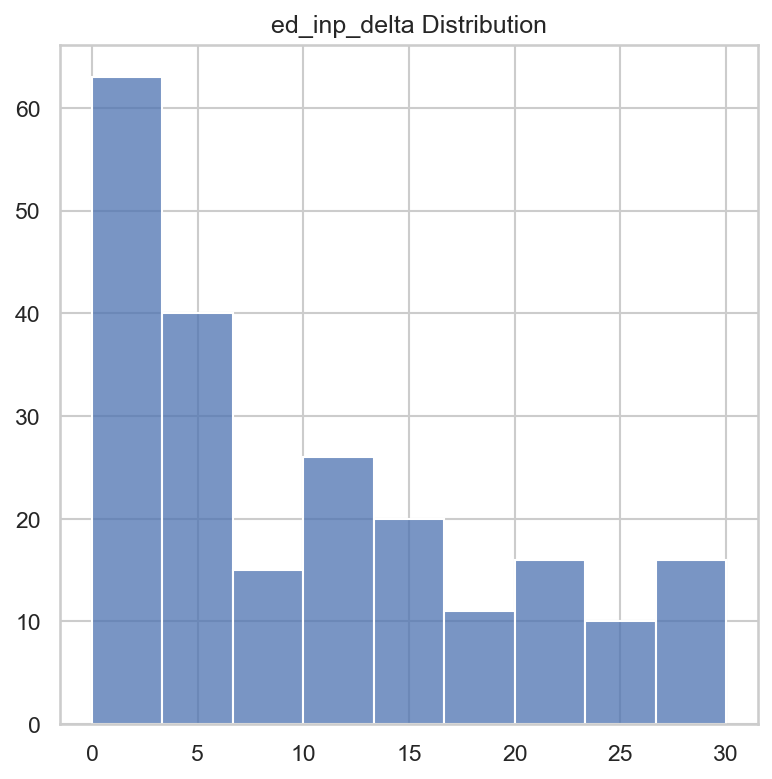

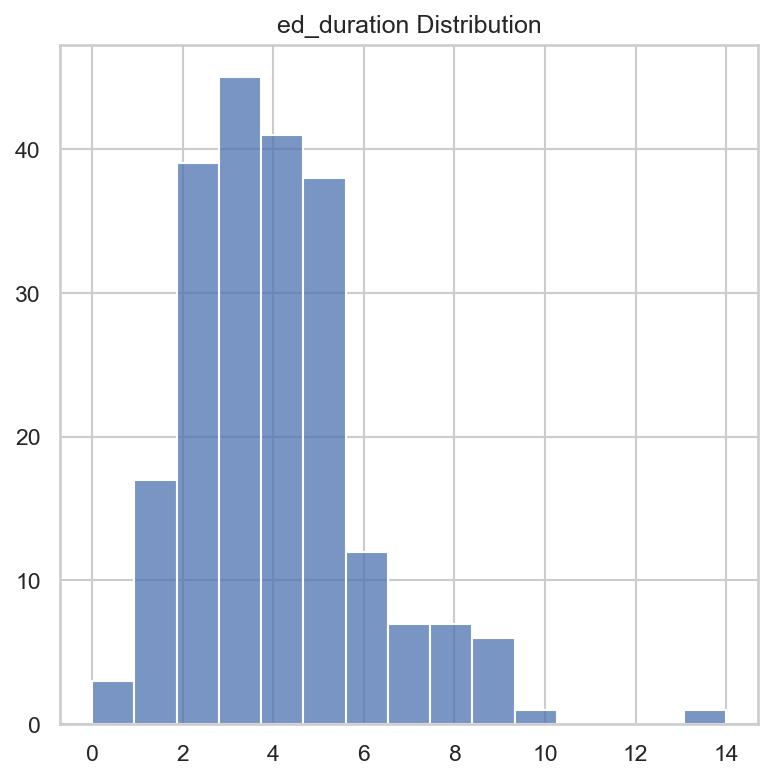

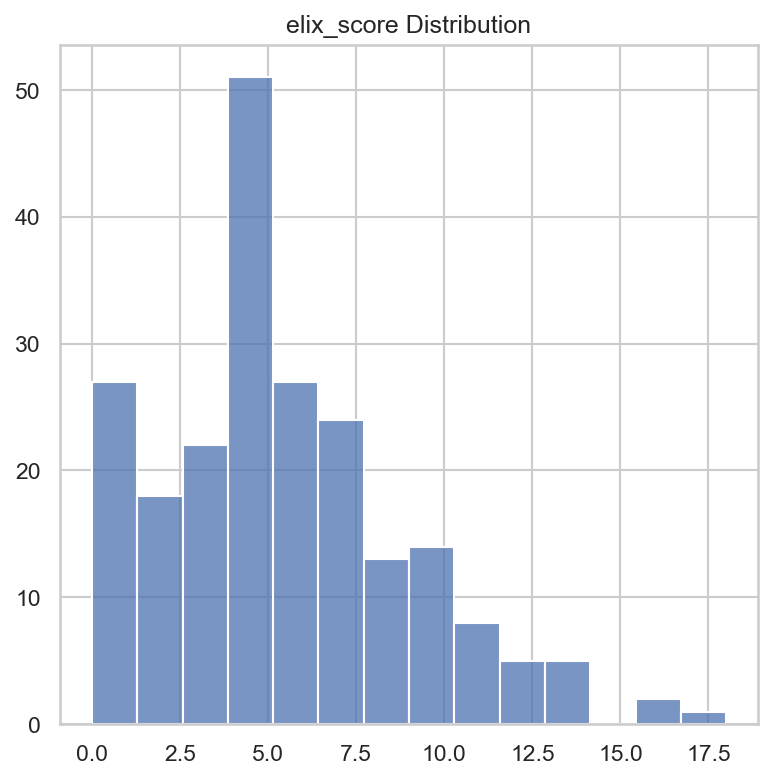

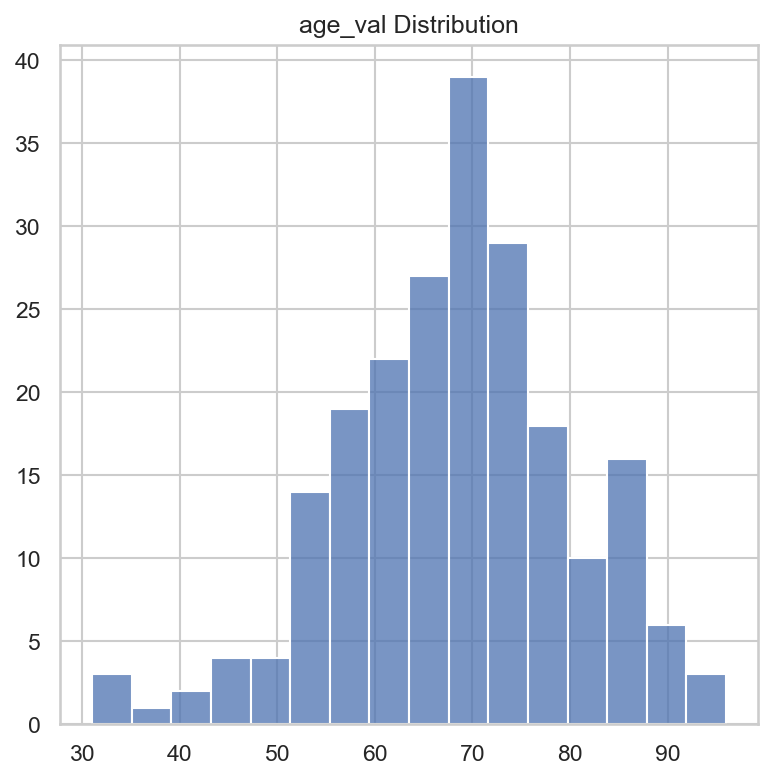

In [23]:
for col in feature_columns_cont:

    # Create figure variables
    fldist_fig, fldist_axes = plt.subplots()
    sns.histplot(data=df, x=col, ax=fldist_axes)

    # Set text
    fldist_axes.set_title(col + ' Distribution')
    fldist_axes.set_ylabel('')
    fldist_axes.set_xlabel('')
    fldist_fig.set_figheight(6)
    fldist_fig.set_figwidth(6)

    # Save figure
    fldist_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], '{}_distributionbylabel.svg'.format(col)))

#### Distribution (Amount) by Label

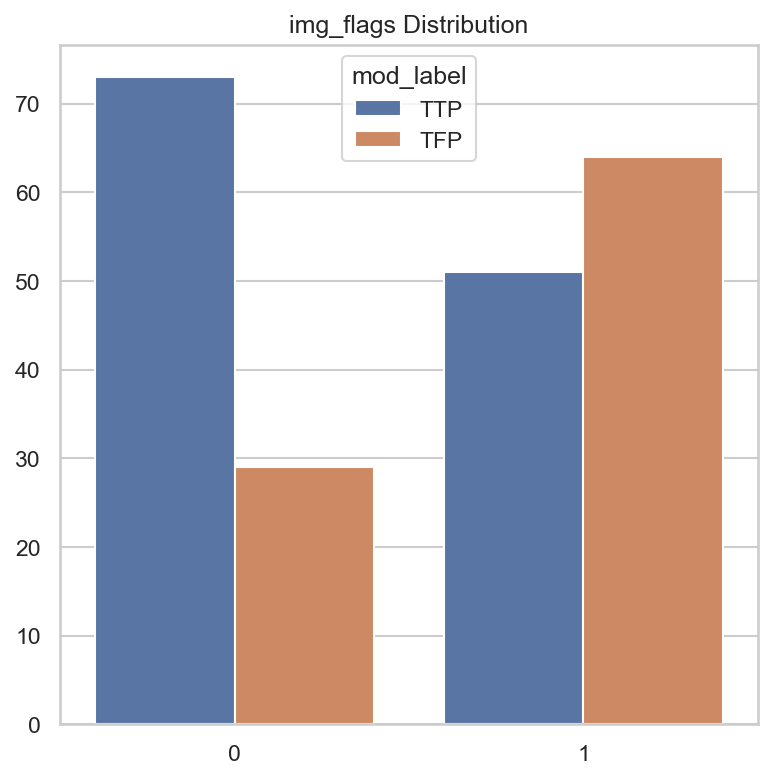

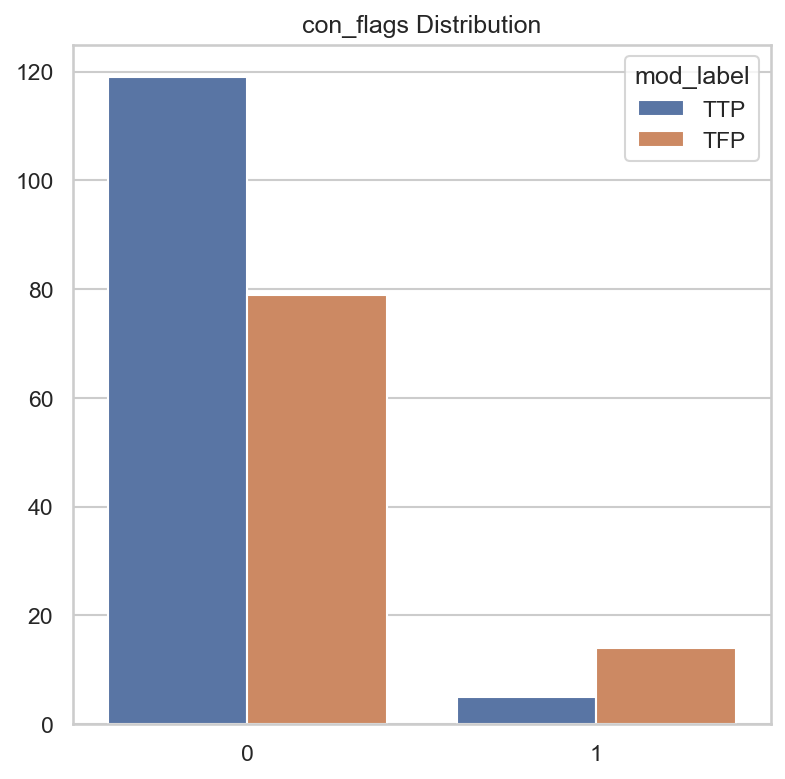

In [24]:
for col in feature_columns_cat:

    # Create figure variables
    fldist_fig, fldist_axes = plt.subplots()
    sns.countplot(data=df, x=col, hue=label_column, ax=fldist_axes)

    # Set text
    fldist_axes.set_title(col + ' Distribution')
    fldist_axes.set_ylabel('')
    fldist_axes.set_xlabel('')
    fldist_fig.set_figheight(6)
    fldist_fig.set_figwidth(6)

    # Save figure
    fldist_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], '{}_distributionbylabel.svg'.format(col)))

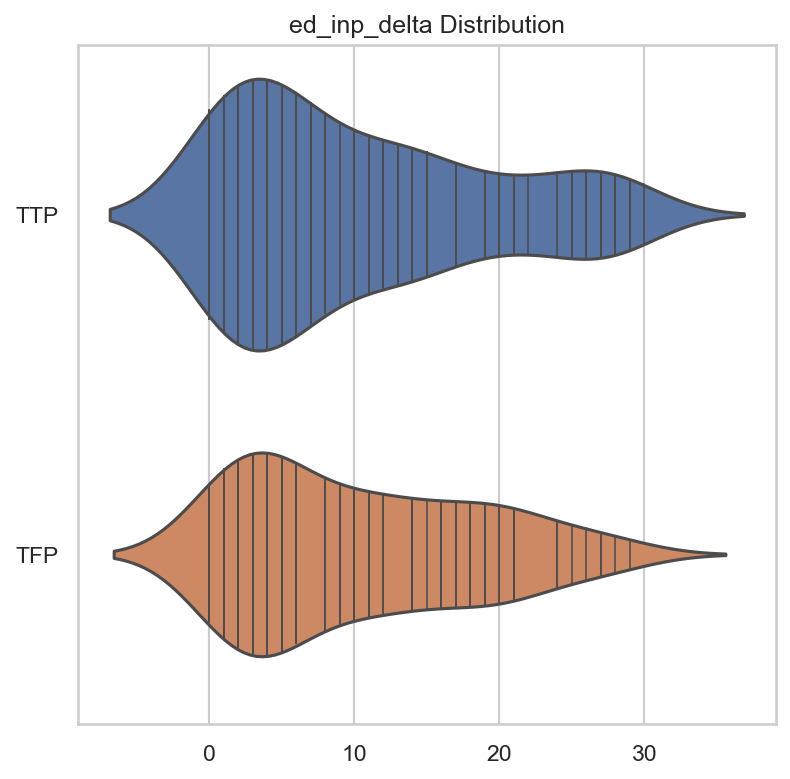

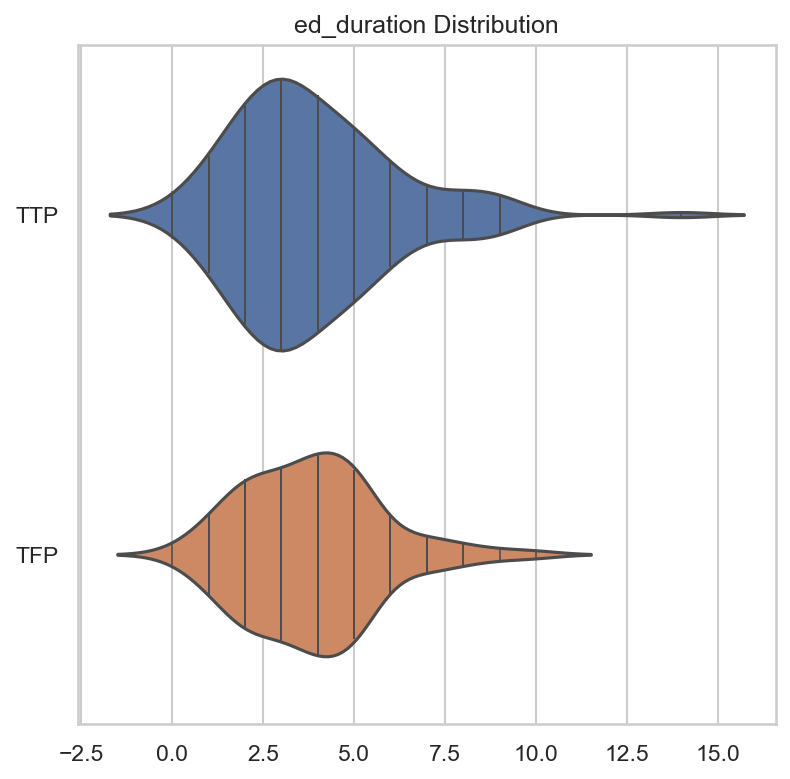

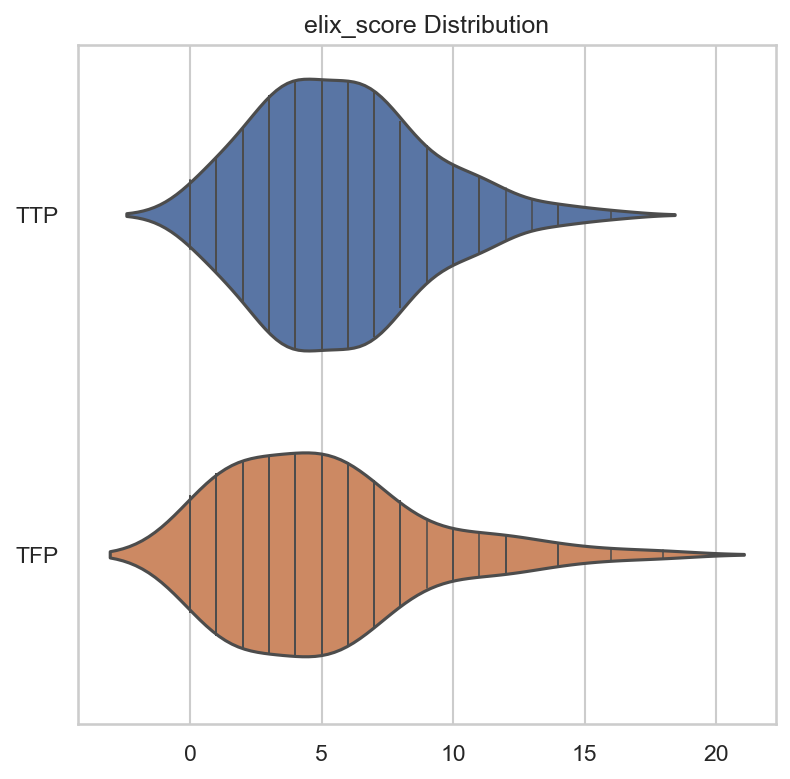

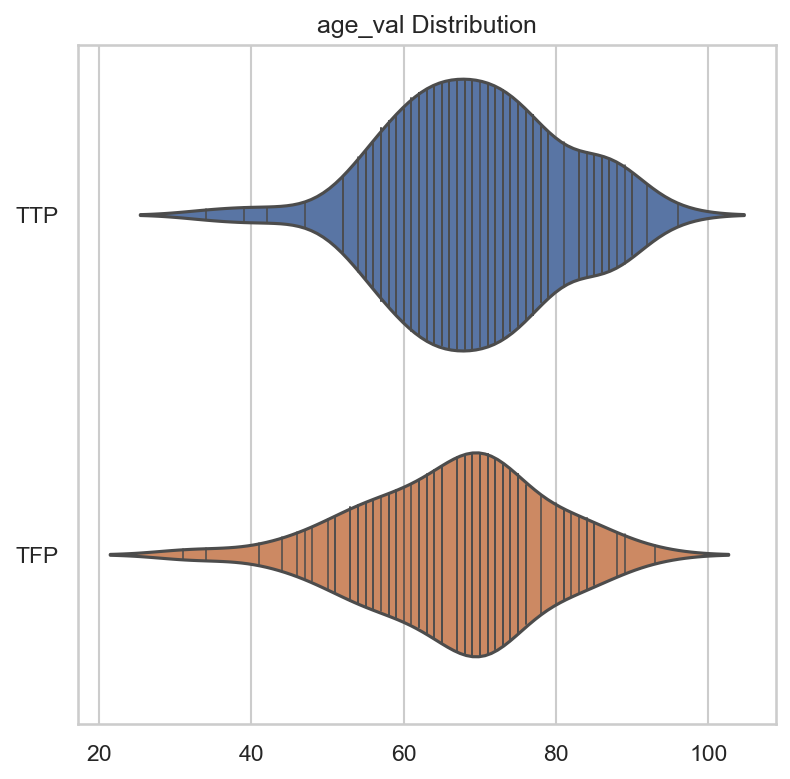

In [25]:
for col in feature_columns_cont:

    # Create figure variables
    fldist_fig, fldist_axes = plt.subplots()
    sns.violinplot(data=df, x=col, y=label_column, scale='count', inner='stick', ax=fldist_axes)

    # Set text
    fldist_axes.set_title(col + ' Distribution')
    fldist_axes.set_ylabel('')
    fldist_axes.set_xlabel('')
    fldist_fig.set_figheight(6)
    fldist_fig.set_figwidth(6)

    # Save figure
    fldist_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], '{}_distributionbylabel.svg'.format(col)))

#### Distribution (Percentage) by Label

In [26]:
def make_stacked_bar(primary_var_vals, secondary_var_vals):
    """
    Parameterss
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(primary_var_vals.keys())
    data = np.array(list(primary_var_vals.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = ['red', 'blue', 'green']

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, colname in enumerate(secondary_var_vals):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5, label=colname)
        xcenters = starts + widths / 2
        
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)), ha='center', va='center')
    ax.legend(ncol=len(secondary_var_vals), bbox_to_anchor=(0, -0.1), loc='lower left', fontsize='small')

    return fig, ax

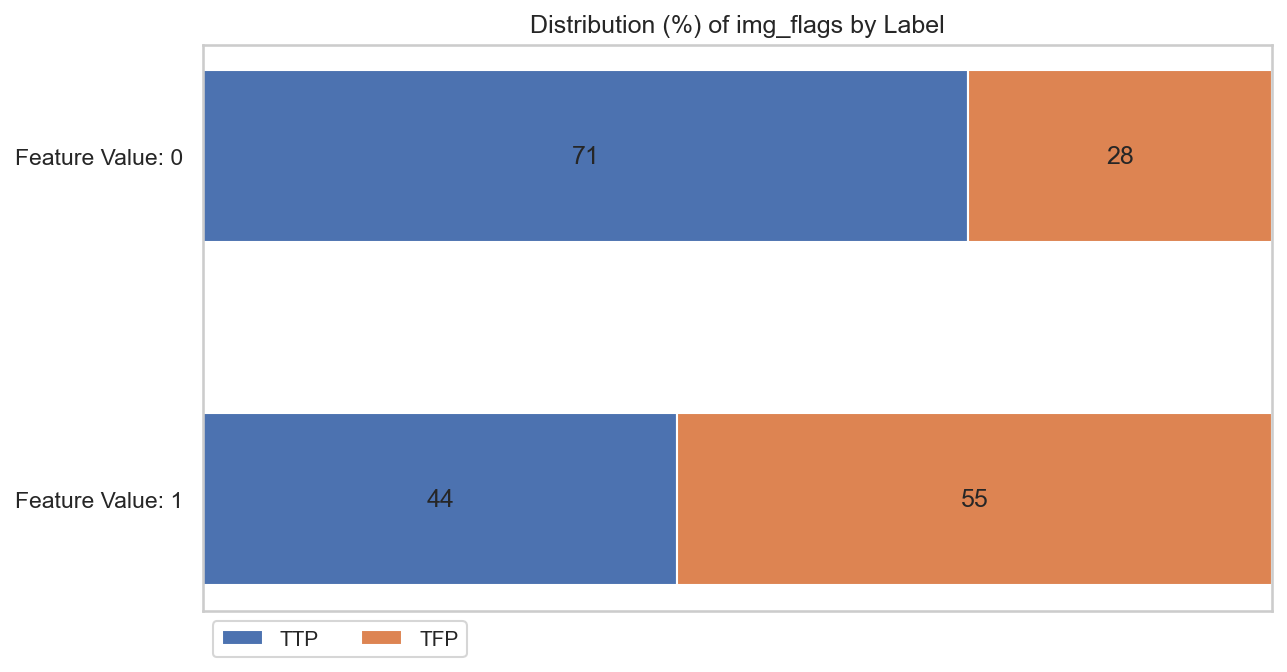

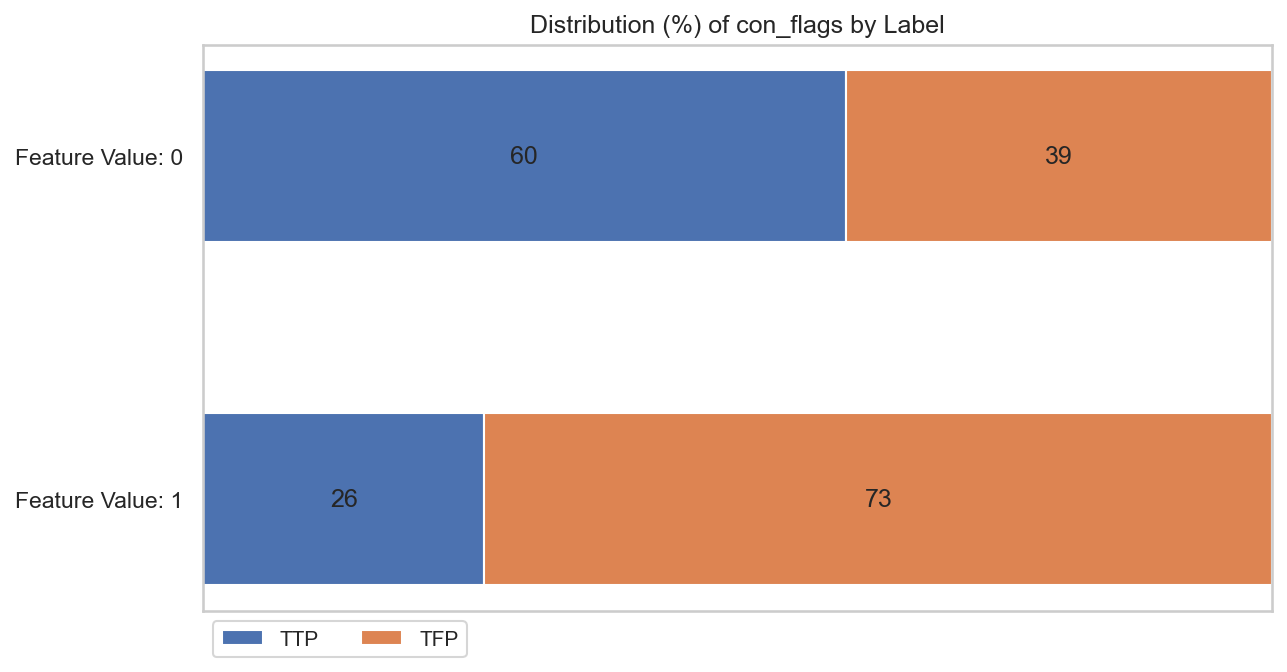

In [27]:
for feat in feature_columns_cat:
    
    primary_var_vals = {}
    secondary_var_vals = list(df[label_column].unique())
    
    for fval in df[feat].unique():
        
        num_fval = len(df[df[feat] == fval].index)
        percent_fval_by_lvals = []
        
        for lval in df[label_column].unique():
            
            num_fval_at_lval = len(df[(df[feat] == fval) & (df[label_column] == lval)].index)
            
            if num_fval == 0:
                percent_fval_at_lval = 0
            else:
                percent_fval_at_lval = (float(num_fval_at_lval)/num_fval) * 100
            
            percent_fval_by_lvals.append(percent_fval_at_lval)
            
        primary_var_vals.update({'Feature Value: {}'.format(fval): percent_fval_by_lvals})
    
    # Create figure variables
    fldist_fig, fldist_axes = make_stacked_bar(primary_var_vals, secondary_var_vals)

    # Set text
    fldist_axes.set_title('Distribution (%) of {} by Label'.format(feat))

    # Save figure
    fldist_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], '{}_distributionbylabel.svg'.format(feat)))

### Labels

#### Distribution

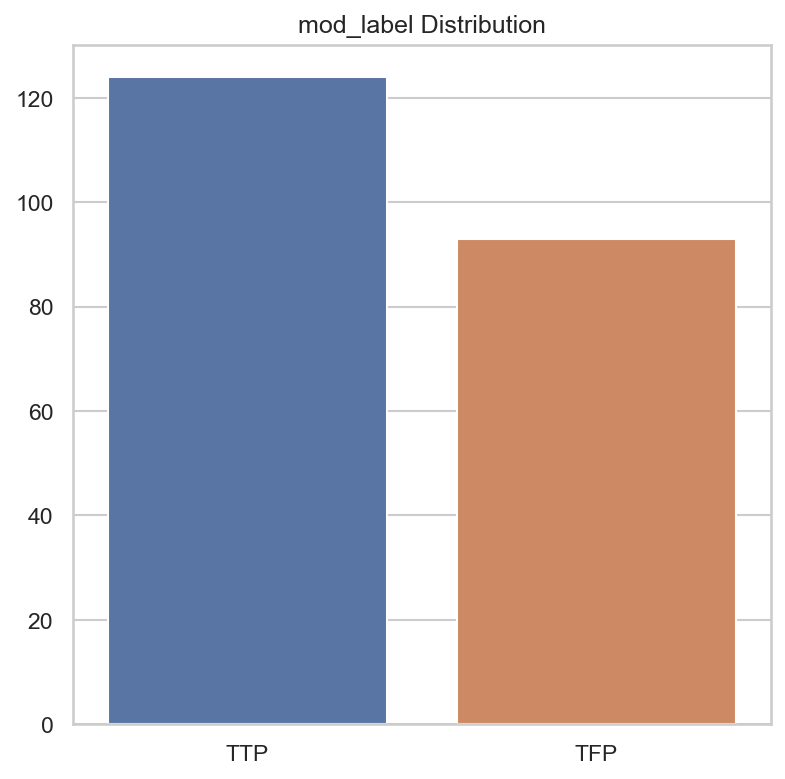

In [28]:
# Create figure variables
fldist_fig, fldist_axes = plt.subplots()
sns.countplot(data=df, x=label_column, ax=fldist_axes)

# Set text
fldist_axes.set_title(label_column + ' Distribution')
fldist_axes.set_ylabel('')
fldist_axes.set_xlabel('')
fldist_fig.set_figheight(6)
fldist_fig.set_figwidth(6)

# Save figure
fldist_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], '{}_distributionbylabel.svg'.format(col)))

#### Distribution by Feature

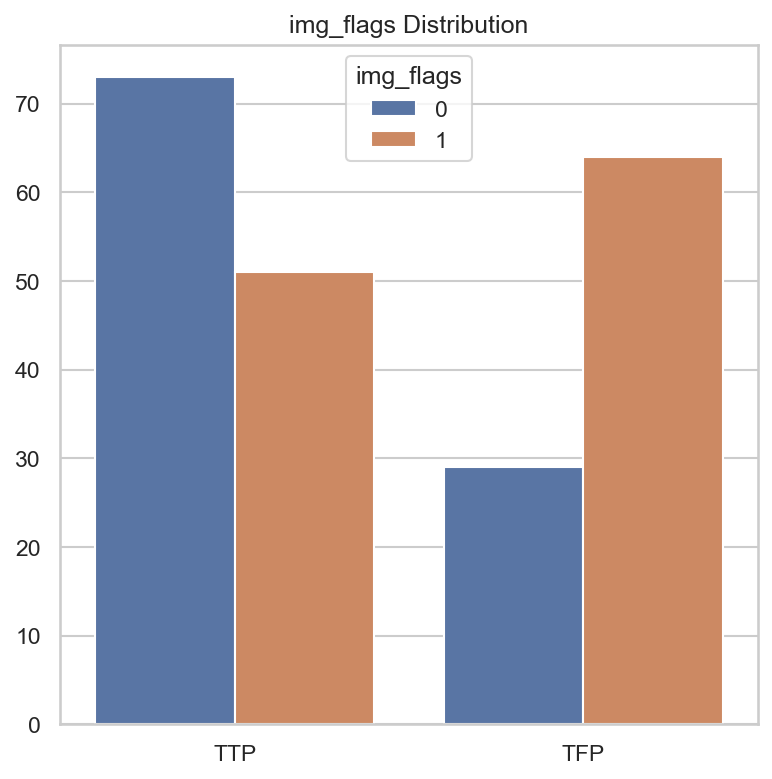

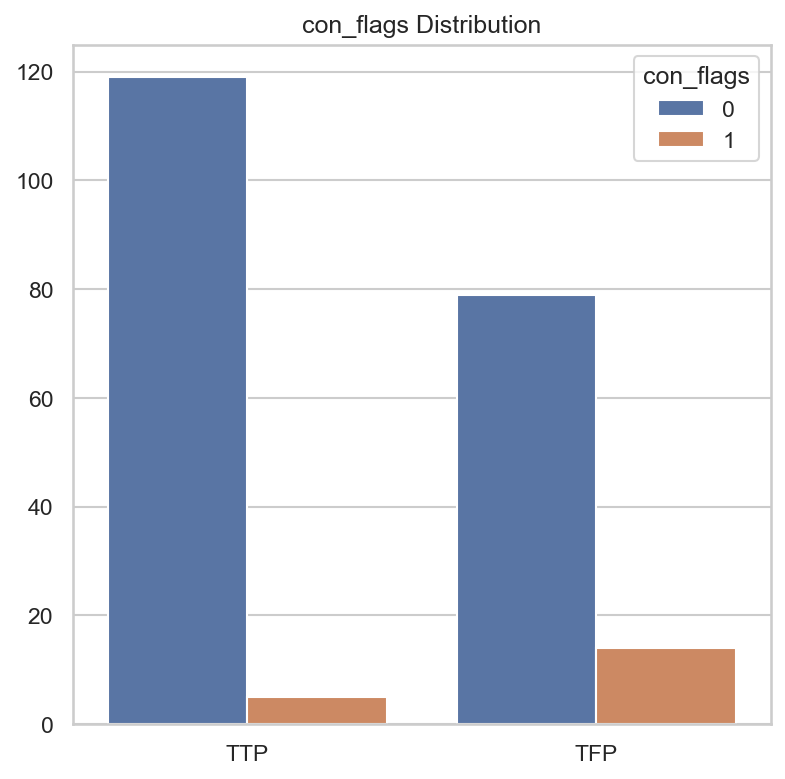

In [30]:
for col in feature_columns_cat:

    # Create figure variables
    fldist_fig, fldist_axes = plt.subplots()
    sns.countplot(data=df, x=label_column, hue=col, ax=fldist_axes)

    # Set text
    fldist_axes.set_title(col + ' Distribution')
    fldist_axes.set_ylabel('')
    fldist_axes.set_xlabel('')
    fldist_fig.set_figheight(6)
    fldist_fig.set_figwidth(6)

    # Save figure
    fldist_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], '{}_distributionbylabel.svg'.format(col)))

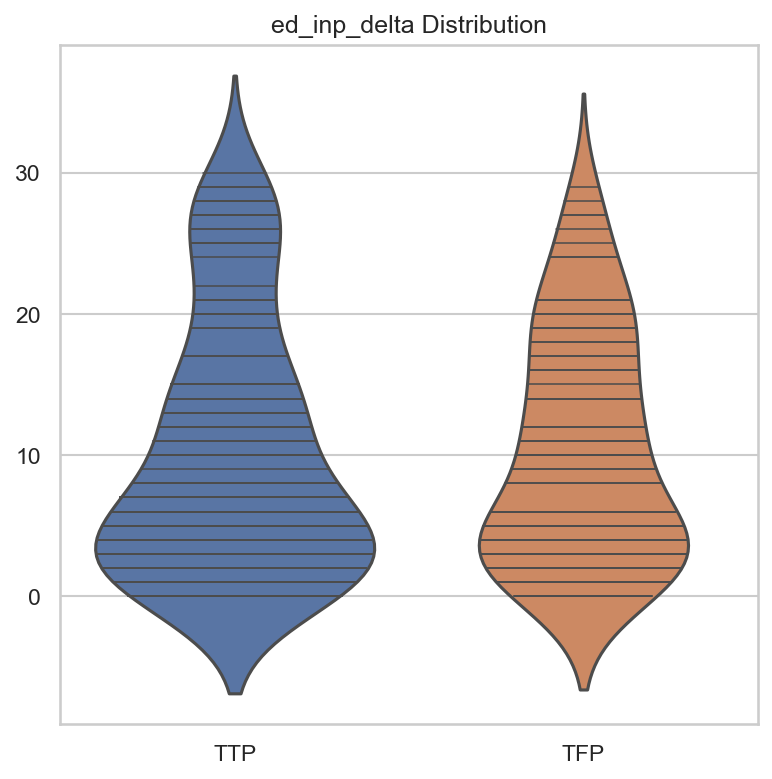

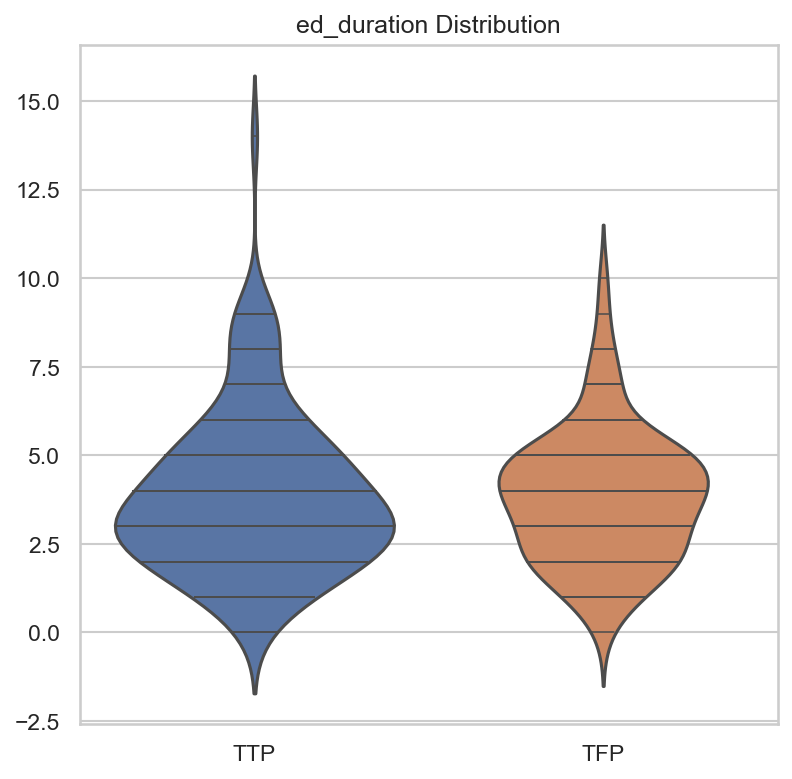

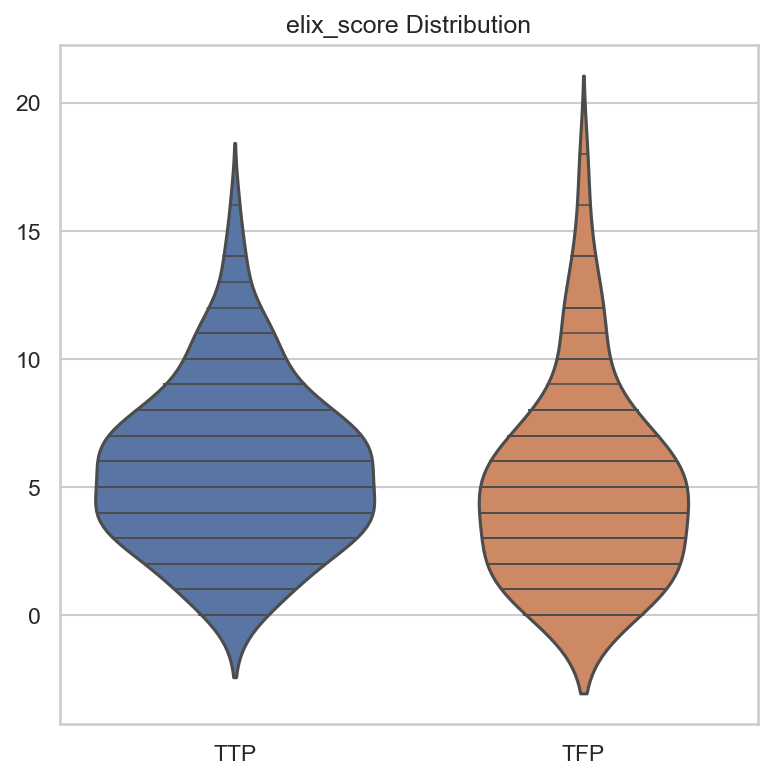

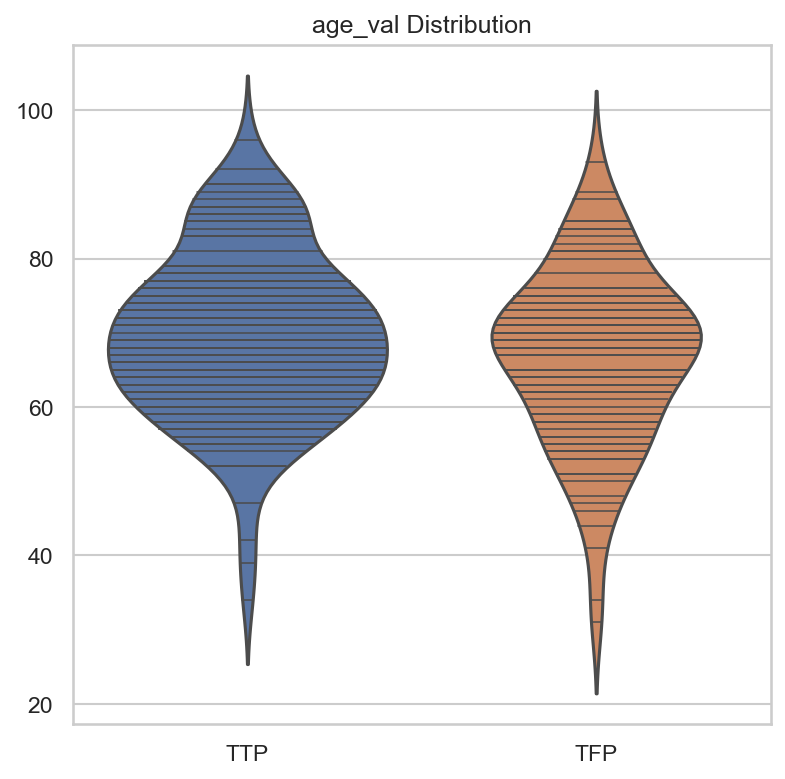

In [31]:
for col in feature_columns_cont:

    # Create figure variables
    fldist_fig, fldist_axes = plt.subplots()
    sns.violinplot(data=df, x=label_column, y=col, scale='count', inner='stick', ax=fldist_axes)

    # Set text
    fldist_axes.set_title(col + ' Distribution')
    fldist_axes.set_ylabel('')
    fldist_axes.set_xlabel('')
    fldist_fig.set_figheight(6)
    fldist_fig.set_figwidth(6)

    # Save figure
    fldist_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], '{}_distributionbylabel.svg'.format(col)))

## Data Preparation

In [32]:
df['ed_inp_delta'] = MinMaxScaler().fit_transform(df['ed_inp_delta'].values.reshape(-1,1))
df['ed_duration'] = MinMaxScaler().fit_transform(df['ed_duration'].values.reshape(-1,1))
df['elix_score'] = MinMaxScaler().fit_transform(df['elix_score'].values.reshape(-1,1))
df['age_val'] = MinMaxScaler().fit_transform(df['age_val'].values.reshape(-1,1))

In [33]:
# split up data
X_train, X_test, y_train, y_test = train_test_split(df[feature_columns], df[label_column], test_size=TEST_SIZE, random_state=RANDOM_STATE_SEED)

## Modeling and Prediction

### Logistic Regression

In [34]:
#TODO: add in RFECV + GridSearchCV

In [35]:
# create a logistic regression model
estimator_log = LogisticRegression(max_iter=LOGISTIC_REGRESSION_ITER, random_state=RANDOM_STATE_SEED, class_weight='balanced')

In [36]:
# define space of model's parameter values
hyperparameter_grid_log = {
    'penalty': ['none', 'l1', 'l2']
    ,'C': np.logspace(-1, 4, 10)
    ,'solver': ['liblinear','saga']
    ,'multi_class': ['ovr']
    ,'fit_intercept': [True, False]
}

The cell below will throw errors but appears to work okay. Some combos of grid search are causing warnings? --AJZ 2022-01-26

In [ ]:
# determine best parameters to fit model ti training data
grid_search_log = GridSearchCV(
    estimator = estimator_log
    ,param_grid = hyperparameter_grid_log
    ,scoring = None
    ,n_jobs = 1
    ,cv = 5
    ,verbose = 0
    ,return_train_score = False
)

best_model_log = grid_search_log.fit(X_train, y_train)

In [39]:
best_model_log

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=42),
             n_jobs=1,
             param_grid={'C': array([1.00000000e-01, 3.59381366e-01, 1.29154967e+00, 4.64158883e+00,
       1.66810054e+01, 5.99484250e+01, 2.15443469e+02, 7.74263683e+02,
       2.78255940e+03, 1.00000000e+04]),
                         'fit_intercept': [True, False], 'multi_class': ['ovr'],
                         'penalty': ['none', 'l1', 'l2'],
                         'solver': ['liblinear', 'saga']})

In [38]:
# print best parameters
print('Best Penalty:', best_model_log.best_estimator_.get_params()['penalty'])
print('Best C:', best_model_log.best_estimator_.get_params()['C'])
print('Best Solver:', best_model_log.best_estimator_.get_params()['solver'])
print('Best Multi-Class:', best_model_log.best_estimator_.get_params()['multi_class'])
print('Best Fit Intercept:', best_model_log.best_estimator_.get_params()['fit_intercept'])

# write best parameters to file
with open(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['MP'], "best_params_log.csv"), "w") as file:
    file.write('Parameter,Value\n')
    file.write('Penalty,{}\n'.format(best_model_log.best_estimator_.get_params()['penalty']))
    file.write('C,{}\n'.format(best_model_log.best_estimator_.get_params()['C']))
    file.write('Solver,{}\n'.format(best_model_log.best_estimator_.get_params()['solver']))
    file.write('Multi-Class,{}\n'.format(best_model_log.best_estimator_.get_params()['multi_class']))
    file.write('Fit Intercept,{}\n'.format(best_model_log.best_estimator_.get_params()['fit_intercept']))

Best Penalty: none
Best C: 0.1
Best Solver: saga
Best Multi-Class: ovr
Best Fit Intercept: True


In [40]:
# get predictions
log_predictions = best_model_log.predict(X_test)

# get probabilities
log_proba = best_model_log.predict_proba(X_test)

In [41]:
# create a line-up of actual values and predictions from each model for that record
prediction_lineup = pd.DataFrame(data=zip(df.loc[X_test.index][label_column].copy(), log_predictions), columns=['Actual MOD Level', 'Log Prediction'], index=X_test.index)

In [42]:
# add probabilities to line up
for idx in range(log_proba.shape[1]):
    prediction_lineup['Log Probability of Label {}'.format(idx)] = log_proba.T[idx]

### Random Forest

In [45]:
# create a random forest model
estimator_rf = RandomForestClassifier(random_state=RANDOM_STATE_SEED, class_weight='balanced')

In [44]:
# define space of model's parameter values
hyperparameter_grid_rf = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350]
    ,'max_depth': [5, 10, 20, 30, 40, 50, 60, None]
}

Grid search is going to take too long. Commented it & just used `n_estimators` and `max_depth` --AJZ 2022-01-26

In [ ]:
# determine best parameters to fit model to training data

#grid_search_rf = GridSearchCV(
#    estimator = estimator_rf
#    ,param_grid = hyperparameter_grid_rf
#    ,scoring = None
#    ,n_jobs = 4
#    ,cv = 5
#    ,verbose = 0
#    ,return_train_score = False
#)

#best_model_rf = grid_search_rf.fit(X_train, y_train)

In [105]:
estimator_rf_new = RandomForestClassifier(random_state=RANDOM_STATE_SEED, class_weight='balanced', n_estimators=50, max_depth=5)
best_model_rf = estimator_rf_new.fit(X_train, y_train)

In [106]:
# skip these because it uses best_estimator_ which doesn't exist

# print best parameters
#print('Best Number of Estimators:', best_model_rf.best_estimator_.get_params()['n_estimators'])
#print('Best Depth:', best_model_rf.best_estimator_.get_params()['max_depth'])

# write best parameters to file
#with open(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['MP'], "best_params_rf.csv"), "w") as file:
#    file.write('Parameter,Value\n')
#    file.write('Number of Estimators,{}\n'.format(best_model_rf.best_estimator_.get_params()['n_estimators']))
#    file.write('Max Depth,{}\n'.format(best_model_rf.best_estimator_.get_params()['max_depth']))

In [50]:
# get predictions
rf_predictions = best_model_rf.predict(X_test)

# get probabilities
rf_proba = best_model_rf.predict_proba(X_test)

In [51]:
# add RF predictions to line up
prediction_lineup['RF Prediction'] = rf_predictions

In [52]:
# add RF probabilities to line up
for idx in range(rf_proba.shape[1]):
    prediction_lineup['RF Probability of Label {}'.format(idx)] = rf_proba.T[idx]

### XGBoost

In [53]:
# create an XGBoost classification model
estimator_xgb = XGBClassifier(seed=RANDOM_STATE_SEED, scale_pos_weight=float(len(y_train[y_train == 'TTP'])/len(y_train[y_train == 'TFP'])))

In [54]:
# define space of model's parameter values
hyperparameter_grid_xgb = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350]
    ,'max_depth': [5, 10, 20, 30, 40, 50, 60, None]
}

Same as before: no grid search. Yes to n estimators & max depth. --AJZ 2022-01-26

In [107]:
# determine best parameters to fit model to training data
#grid_search_xgb = GridSearchCV(
#    estimator = estimator_xgb
#    ,param_grid = hyperparameter_grid_xgb
#    ,scoring = None
#    ,n_jobs = 1
#    ,cv = 5
#    ,verbose = 0
#    ,return_train_score = False
#)

#best_model_xgb = grid_search_xgb.fit(X_train, y_train)

In [56]:
estimator_xgb = XGBClassifier(seed=RANDOM_STATE_SEED, scale_pos_weight=float(len(y_train[y_train == 'TTP'])/len(y_train[y_train == 'TFP'])), n_estimators=50, max_depth=5)
best_model_xgb = estimator_xgb.fit(X_train, y_train)

[15:51:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [108]:
# print best parameters
#print('Best Number of Estimators:', best_model_xgb.best_estimator_.get_params()['n_estimators'])
#print('Best Depth:', best_model_xgb.best_estimator_.get_params()['max_depth'])

# write best parameters to file
#with open(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['MP'], "best_params_xgb.csv"), "w") as file:
#    file.write('Parameter,Value\n')
#    file.write('Number of Estimators,{}\n'.format(best_model_xgb.best_estimator_.get_params()['n_estimators']))
#    file.write('Max Depth,{}\n'.format(best_model_xgb.best_estimator_.get_params()['max_depth']))

In [109]:
# get predictions
xgb_predictions = best_model_xgb.predict(X_test)

# get probabilities
xgb_proba = best_model_xgb.predict_proba(X_test)

In [110]:
# add XGB predictions to line up
prediction_lineup['XGB Prediction'] = xgb_predictions

In [111]:
# add XGB probabilities to line up
for idx in range(xgb_proba.shape[1]):
    prediction_lineup['XGB Probability of Label {}'.format(idx)] = xgb_proba.T[idx]

In [112]:
prediction_lineup.to_csv(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['MP'], 'prediction_lineup.csv'), index=True)

## Model Evaluation

### ROC AUC

In [113]:
# create metrics dataframe
metrics_df = pd.DataFrame(data=['Log', 'RF', 'XGB'], columns=['Model'])

In [114]:
display(metrics_df)

,Model
0,Log
1,RF
2,XGB


In [115]:
# calculate ROC AUC scores
roc_auc_log = metrics.roc_auc_score(y_test, log_proba[:,1])
roc_auc_rf = metrics.roc_auc_score(y_test, rf_proba[:,1])
roc_auc_xgb = metrics.roc_auc_score(y_test, xgb_proba[:,1])

# print ROC AUC scores
print('ROC AUC Scores')
print('------------------------')
print('Log: {}'.format(roc_auc_log))
print('RF: {}'.format(roc_auc_rf))
print('XGB: {}'.format(roc_auc_xgb))

metrics_df['ROC_AUC Score'] = [roc_auc_log, roc_auc_rf, roc_auc_xgb]

ROC AUC Scores
------------------------
Log: 0.8270676691729323
RF: 0.7857142857142858
XGB: 0.7706766917293233


### Confusion Matrices

In [65]:
# create confusion matrices for each model
confusion_matrix_log = pd.DataFrame(data=metrics.confusion_matrix(y_test, log_predictions), columns=['Predicted Label 0', 'Predicted Label 1'], index=['Actual Label 0', 'Actual Label 1'])
confusion_matrix_rf = pd.DataFrame(data=metrics.confusion_matrix(y_test, rf_predictions), columns=['Predicted Label 0', 'Predicted Label 1'], index=['Actual Label 0', 'Actual Label 1'])
confusion_matrix_xgb = pd.DataFrame(data=metrics.confusion_matrix(y_test, xgb_predictions), columns=['Predicted Label 0', 'Predicted Label 1'], index=['Actual Label 0', 'Actual Label 1'])

# print confusion matrices (actual on left side, predicted on top)
print('ROC AUC Scores')
print('------------------------')
print('Log:')
print(metrics.confusion_matrix(y_test, log_predictions))
print()
print('RF:')
print(metrics.confusion_matrix(y_test, rf_predictions))
print()
print('XGBoost:')
print(metrics.confusion_matrix(y_test, xgb_predictions))

# write confusion matrices to file
confusion_matrix_log.to_csv(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['ME'], 'confusion_matrix_log.csv'), index=True)
confusion_matrix_rf.to_csv(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['ME'], 'confusion_matrix_rf.csv'), index=True)
confusion_matrix_xgb.to_csv(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['ME'], 'confusion_matrix_xgb.csv'), index=True)

ROC AUC Scores
------------------------
Log:
[[14  5]
 [ 3 11]]

RF:
[[14  5]
 [ 5  9]]

XGBoost:
[[15  4]
 [ 7  7]]


### Classification Reports

In [66]:
print(metrics.classification_report(y_test, log_predictions))

              precision    recall  f1-score   support

         TFP       0.82      0.74      0.78        19
         TTP       0.69      0.79      0.73        14

    accuracy                           0.76        33
   macro avg       0.76      0.76      0.76        33
weighted avg       0.77      0.76      0.76        33



In [67]:
print(metrics.classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

         TFP       0.74      0.74      0.74        19
         TTP       0.64      0.64      0.64        14

    accuracy                           0.70        33
   macro avg       0.69      0.69      0.69        33
weighted avg       0.70      0.70      0.70        33



In [68]:
print(metrics.classification_report(y_test, xgb_predictions))

              precision    recall  f1-score   support

         TFP       0.68      0.79      0.73        19
         TTP       0.64      0.50      0.56        14

    accuracy                           0.67        33
   macro avg       0.66      0.64      0.65        33
weighted avg       0.66      0.67      0.66        33



### Confusion Matrix Metrics

In [69]:
# create confusion matrix metrics objects for each model
confusion_matrix_metrics_log = cm_metrics.confusion_matrix_metrics(metrics.confusion_matrix(y_test,log_predictions).T)
confusion_matrix_metrics_rf = cm_metrics.confusion_matrix_metrics(metrics.confusion_matrix(y_test,rf_predictions).T)
confusion_matrix_metrics_xgb = cm_metrics.confusion_matrix_metrics(metrics.confusion_matrix(y_test,xgb_predictions).T)

In [70]:
# calculate mean confusion matrix metrics for each object
metrics_df['PPV (mean)'] = [
    np.mean(confusion_matrix_metrics_log.get_ppv()), 
    np.mean(confusion_matrix_metrics_rf.get_ppv()), 
    np.mean(confusion_matrix_metrics_xgb.get_ppv())
]

metrics_df['NPV (mean)'] = [
    np.mean(confusion_matrix_metrics_log.get_npv()), 
    np.mean(confusion_matrix_metrics_rf.get_npv()), 
    np.mean(confusion_matrix_metrics_xgb.get_npv())
]

metrics_df['Sensitivity (mean)'] = [
    np.mean(confusion_matrix_metrics_log.get_sensitivity()), 
    np.mean(confusion_matrix_metrics_rf.get_sensitivity()), 
    np.mean(confusion_matrix_metrics_xgb.get_sensitivity())
]

metrics_df['Specificity (mean)'] = [
    np.mean(confusion_matrix_metrics_log.get_specificity()), 
    np.mean(confusion_matrix_metrics_rf.get_specificity()), 
    np.mean(confusion_matrix_metrics_xgb.get_specificity())
]

In [71]:
# calculate weighted mean confusion matrix metrics for each object
metrics_df['PPV (weighted mean)'] = [
    np.average(confusion_matrix_metrics_log.get_ppv(), weights=confusion_matrix_metrics_log.calc_condition_amount()),
    np.average(confusion_matrix_metrics_rf.get_ppv(), weights=confusion_matrix_metrics_rf.calc_condition_amount()), 
    np.average(confusion_matrix_metrics_xgb.get_ppv(), weights=confusion_matrix_metrics_xgb.calc_condition_amount())
]

metrics_df['NPV (weighted mean)'] = [
    np.average(confusion_matrix_metrics_log.get_npv(), weights=confusion_matrix_metrics_log.calc_condition_amount()),
    np.average(confusion_matrix_metrics_rf.get_npv(), weights=confusion_matrix_metrics_rf.calc_condition_amount()), 
    np.average(confusion_matrix_metrics_xgb.get_npv(), weights=confusion_matrix_metrics_xgb.calc_condition_amount())
]

metrics_df['Sensitivity (weighted mean)'] = [
    np.average(confusion_matrix_metrics_log.get_sensitivity(), weights=confusion_matrix_metrics_log.calc_condition_amount()),
    np.average(confusion_matrix_metrics_rf.get_sensitivity(), weights=confusion_matrix_metrics_rf.calc_condition_amount()), 
    np.average(confusion_matrix_metrics_xgb.get_sensitivity(), weights=confusion_matrix_metrics_xgb.calc_condition_amount())
]

metrics_df['Specificity (weighted mean)'] = [
    np.average(confusion_matrix_metrics_log.get_specificity(), weights=confusion_matrix_metrics_log.calc_condition_amount()),
    np.average(confusion_matrix_metrics_rf.get_specificity(), weights=confusion_matrix_metrics_rf.calc_condition_amount()), 
    np.average(confusion_matrix_metrics_xgb.get_specificity(), weights=confusion_matrix_metrics_xgb.calc_condition_amount())
]

In [72]:
# get metrics for each label
for idx in range(xgb_proba.shape[1]):
    metrics_df['PPV for Label {}'.format(idx)] = [confusion_matrix_metrics_log.get_ppv()[idx], 
                                                    confusion_matrix_metrics_rf.get_ppv()[idx], 
                                                    confusion_matrix_metrics_xgb.get_ppv()[idx]]
    
for idx in range(xgb_proba.shape[1]):
    metrics_df['NPV for Label {}'.format(idx)] = [confusion_matrix_metrics_log.get_npv()[idx], 
                                                    confusion_matrix_metrics_rf.get_npv()[idx], 
                                                    confusion_matrix_metrics_xgb.get_npv()[idx]]
    
for idx in range(xgb_proba.shape[1]):
    metrics_df['Sensitivity for Label {}'.format(idx)] = [confusion_matrix_metrics_log.get_sensitivity()[idx], 
                                                            confusion_matrix_metrics_rf.get_sensitivity()[idx], 
                                                            confusion_matrix_metrics_xgb.get_sensitivity()[idx]]

for idx in range(xgb_proba.shape[1]):
    metrics_df['Specificity for Label {}'.format(idx)] = [confusion_matrix_metrics_log.get_specificity()[idx], 
                                                            confusion_matrix_metrics_rf.get_specificity()[idx], 
                                                            confusion_matrix_metrics_xgb.get_specificity()[idx]]

In [73]:
# print out metrics
metrics_df_temp = metrics_df.copy().T
metrics_df_temp.columns = metrics_df_temp.iloc[0]
metrics_df_temp

Model,Log,RF,XGB
Model,Log,RF,XGB
ROC_AUC Score,0.827068,0.785714,0.770677
PPV (mean),0.755515,0.68985,0.659091
NPV (mean),0.755515,0.68985,0.659091
Sensitivity (mean),0.761278,0.68985,0.644737
Specificity (mean),0.761278,0.68985,0.644737
PPV (weighted mean),0.76582,0.69697,0.662534
NPV (weighted mean),0.745209,0.68273,0.655647
Sensitivity (weighted mean),0.757576,0.69697,0.666667
Specificity (weighted mean),0.764981,0.68273,0.622807


In [74]:
# write metrics to file
metrics_df.to_csv(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['ME'], 'cm_metrics.csv'), index=True)

In [ ]:
merged_prediction_lineup = pd.merge(prediction_lineup, df, left_index=True, right_index=True)

In [ ]:
for col in feature_columns_cont:

    # Create figure variables
    fldist_fig, fldist_axes = plt.subplots()
    sns.scatterplot(data=merged_prediction_lineup, y='Log Probability of Label 0', x=col, hue='Actual MOD Level', ax=fldist_axes)

    # Set text
    fldist_axes.set_title('LRM Probability of Label 0 by {}'.format(col))
    fldist_axes.set_ylabel('')
    fldist_axes.set_xlabel('')
    fldist_fig.set_figheight(6)
    fldist_fig.set_figwidth(6)

    # Save figure
    fldist_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], '{}_distributionbylabel.svg'.format(col)))

In [ ]:
for col in feature_columns_cat:

    # Create figure variables
    fldist_fig, fldist_axes = plt.subplots()
    sns.swarmplot(data=merged_prediction_lineup, y='Log Probability of Label 0', x=col, hue='Actual MOD Level', ax=fldist_axes)

    # Set text
    fldist_axes.set_title('LRM Probability of Label 0 by {}'.format(col))
    fldist_axes.set_ylabel('')
    fldist_axes.set_xlabel('')
    fldist_fig.set_figheight(6)
    fldist_fig.set_figwidth(6)

    # Save figure
    fldist_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], '{}_distributionbylabel.svg'.format(col)))

## Model Analysis and Visualization

### Logistic Regression

In [75]:
# create dataframe of all feature coefficients
log_coefs = pd.DataFrame(data=best_model_log.best_estimator_.coef_.T, columns=['Coef'], index=df[feature_columns].columns)
log_coefs['Absolute Value'] = log_coefs.abs().mean(axis=1)
log_coefs = log_coefs.reindex(log_coefs.abs().sort_values(by='Absolute Value', ascending=False).index)

In [76]:
log_coefs

,Coef,Absolute Value
ed_duration,1.422750,1.422750
age_val,1.399854,1.399854
img_flags,-1.166466,1.166466
con_flags,-1.064563,1.064563
ed_inp_delta,-0.503261,0.503261
elix_score,0.497150,0.497150


C:\Users\VHAHOUZimolA\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


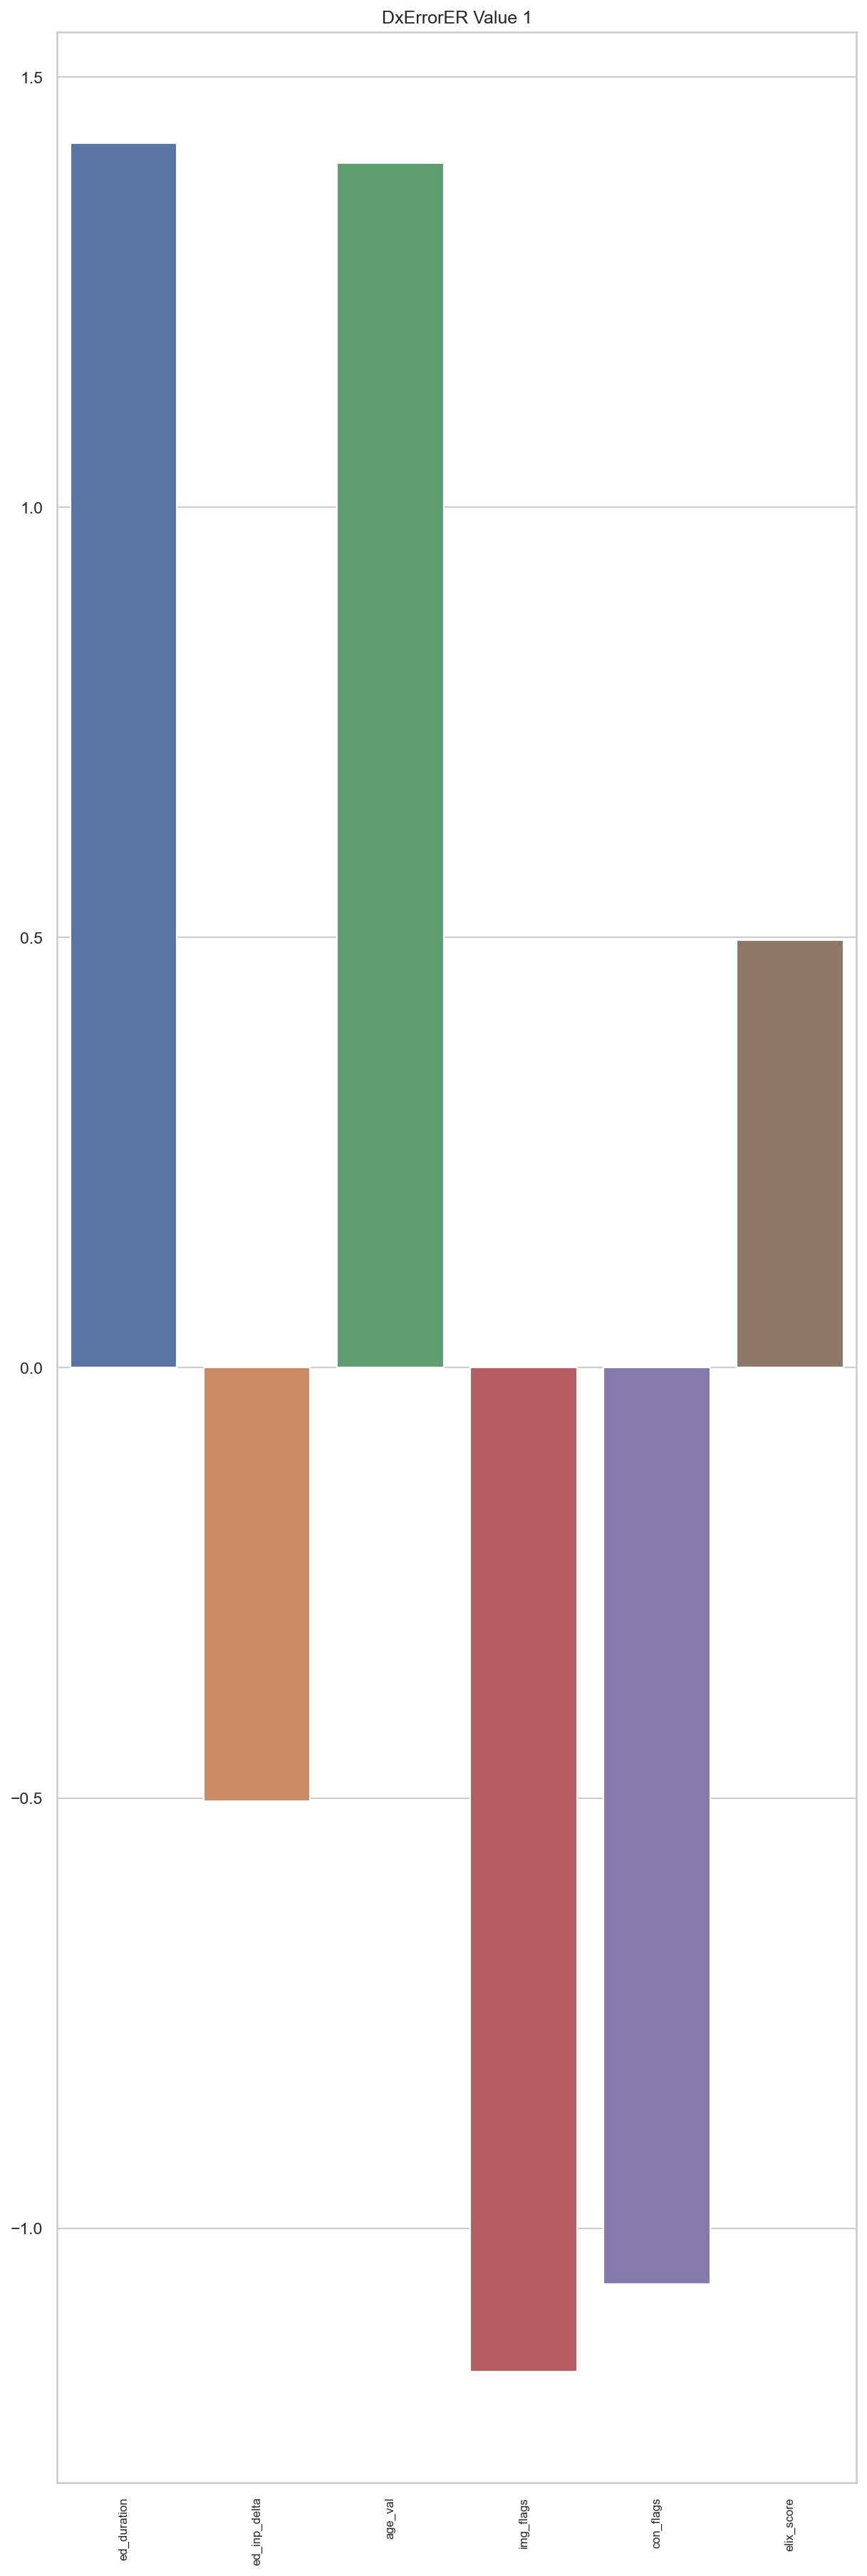

In [77]:
#get coefficients for each label
coefs = best_model_log.best_estimator_.coef_.T

#create list of all label names
class_names = range(1,2)

# create figure and specify layout
fig = plt.figure(figsize=(8,24), constrained_layout=True)
spec = gridspec.GridSpec(nrows=len(class_names), ncols=1, figure=fig)

# create and arrange axes
axes = []
for irow in range(len(class_names)):
    iaxes_row = []
    for icol in range(1):
        iaxes_row.append(fig.add_subplot(spec[irow,icol]))
    axes.append(iaxes_row)

# Plot graph for each label
for class_name in class_names:
    chart = sns.barplot(feature_columns,coefs[:,class_name-1], ax=axes[class_name-1][0])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90,fontsize=8)
    chart.set_title('DxErrorER Value {}'.format(class_name))
    
    # Save graph when done
    if class_name == list(class_names)[-1]:
        dummy_plot = chart.get_figure()
        dummy_plot.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['MAV'], 'predictor_strength_all_log.svg'))

In [78]:
# print top 20 predictors
log_coefs.head(20)

,Coef,Absolute Value
ed_duration,1.422750,1.422750
age_val,1.399854,1.399854
img_flags,-1.166466,1.166466
con_flags,-1.064563,1.064563
ed_inp_delta,-0.503261,0.503261
elix_score,0.497150,0.497150


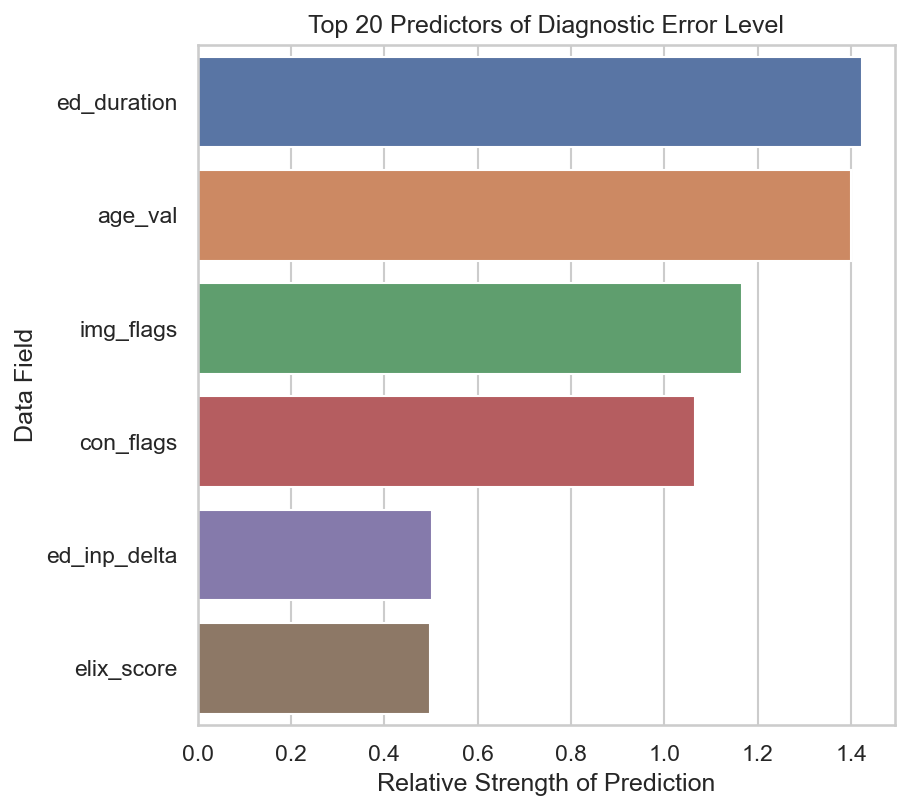

In [79]:
# create graph variables
log_coefs_20_fig, log_coefs_20_axes = plt.subplots()

temp_data = log_coefs.head(20)['Absolute Value']

sns.barplot(y=temp_data.index, x=temp_data.values, ax=log_coefs_20_axes)

# set text
log_coefs_20_axes.set_title('Top 20 Predictors of Diagnostic Error Level')
log_coefs_20_axes.set_ylabel('Data Field')
log_coefs_20_axes.set_xlabel('Relative Strength of Prediction')

# save figure
log_coefs_20_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['MAV'], 'predictor_strength_20_log.svg'))

### Random Forest Model

In [82]:
# create a dataframe of feature importances
rf_importances = pd.DataFrame(data=best_model_rf.feature_importances_, columns=['Feature Importance'], index=feature_columns)
rf_importances = rf_importances.sort_values(by=['Feature Importance'], ascending=False)

In [83]:
# print the feature importances dataframe
rf_importances

,Feature Importance
ed_inp_delta,0.248525
elix_score,0.221923
age_val,0.217693
img_flags,0.131174
ed_duration,0.124201
con_flags,0.056483


In [84]:
# print the top 20 feature importances
rf_importances.head(20)

,Feature Importance
ed_inp_delta,0.248525
elix_score,0.221923
age_val,0.217693
img_flags,0.131174
ed_duration,0.124201
con_flags,0.056483


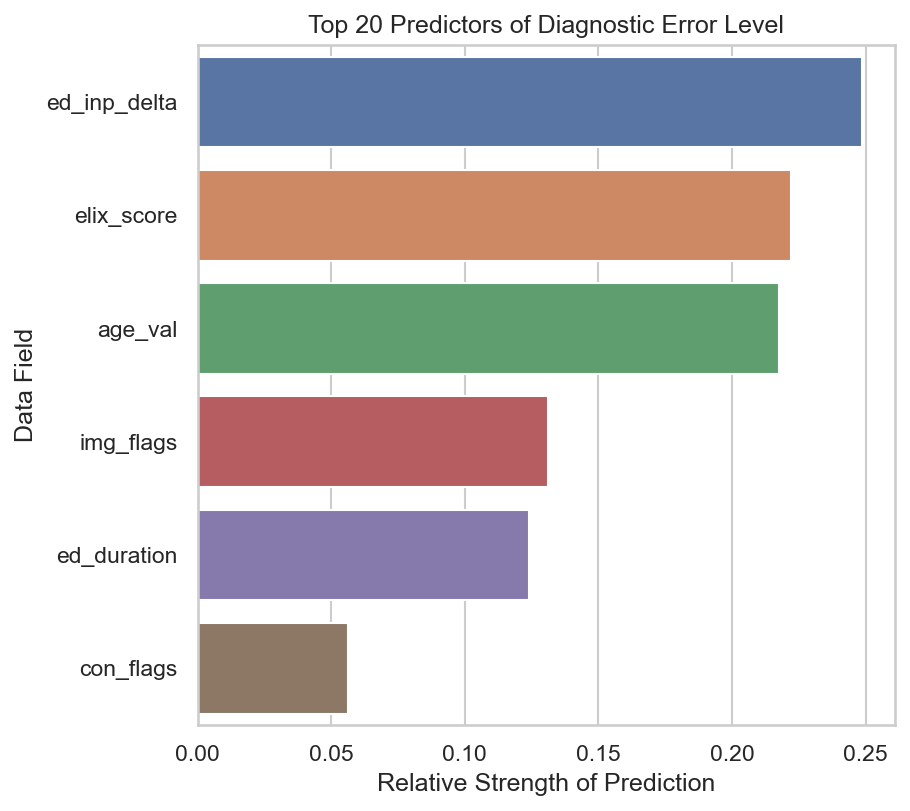

In [85]:
# create figure variables
rf_importances_20_fig, rf_importances_20_axes = plt.subplots()

temp_data = rf_importances.head(20)['Feature Importance']
sns.barplot(y=temp_data.index, x=temp_data.values, ax=rf_importances_20_axes)

# set text
rf_importances_20_axes.set_title('Top 20 Predictors of Diagnostic Error Level')
rf_importances_20_axes.set_ylabel('Data Field')
rf_importances_20_axes.set_xlabel('Relative Strength of Prediction')

# save figure
rf_importances_20_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['MAV'], 'predictor_strength_20_rf.svg'))

### XGBoost Model

In [87]:
# create a dataframe of feature importances
xgb_importances = pd.DataFrame(data=best_model_xgb.feature_importances_, columns=['Feature Importance'], index=feature_columns)
xgb_importances = xgb_importances.sort_values(by=['Feature Importance'], ascending=False)

In [88]:
# print the feature importances dataframe
xgb_importances

,Feature Importance
con_flags,0.344825
img_flags,0.167889
elix_score,0.152945
age_val,0.126331
ed_inp_delta,0.116667
ed_duration,0.091342


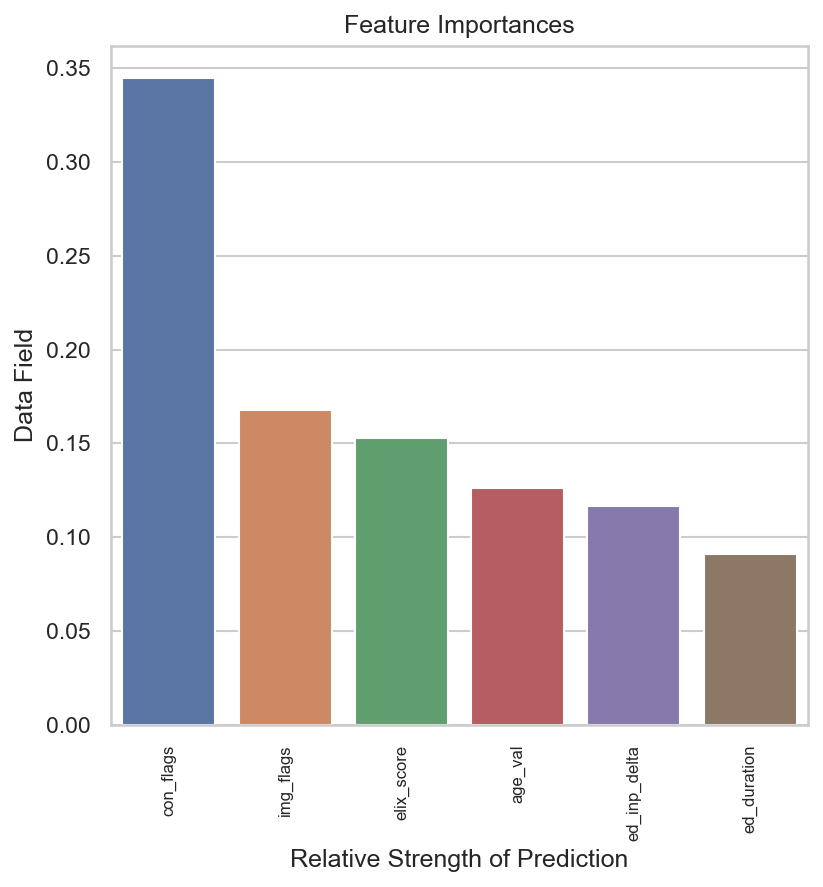

In [89]:
# create graph variables
xgb_importances_fig, xgb_importances_axes = plt.subplots()

temp_data = xgb_importances['Feature Importance']

sns.barplot(x=temp_data.index, y=temp_data.values, ax=xgb_importances_axes)

# set text
xgb_importances_axes.set_title('Feature Importances')
xgb_importances_axes.set_ylabel('Data Field')
xgb_importances_axes.set_xlabel('Relative Strength of Prediction')
xgb_importances_axes.set_xticklabels(xgb_importances_axes.get_xticklabels(), rotation=90,fontsize=8)

# save figure
xgb_importances_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['MAV'], 'predictor_strength_all_xgb.svg'))

In [90]:
# print the top 20 feature importances
xgb_importances.head(20)

,Feature Importance
con_flags,0.344825
img_flags,0.167889
elix_score,0.152945
age_val,0.126331
ed_inp_delta,0.116667
ed_duration,0.091342


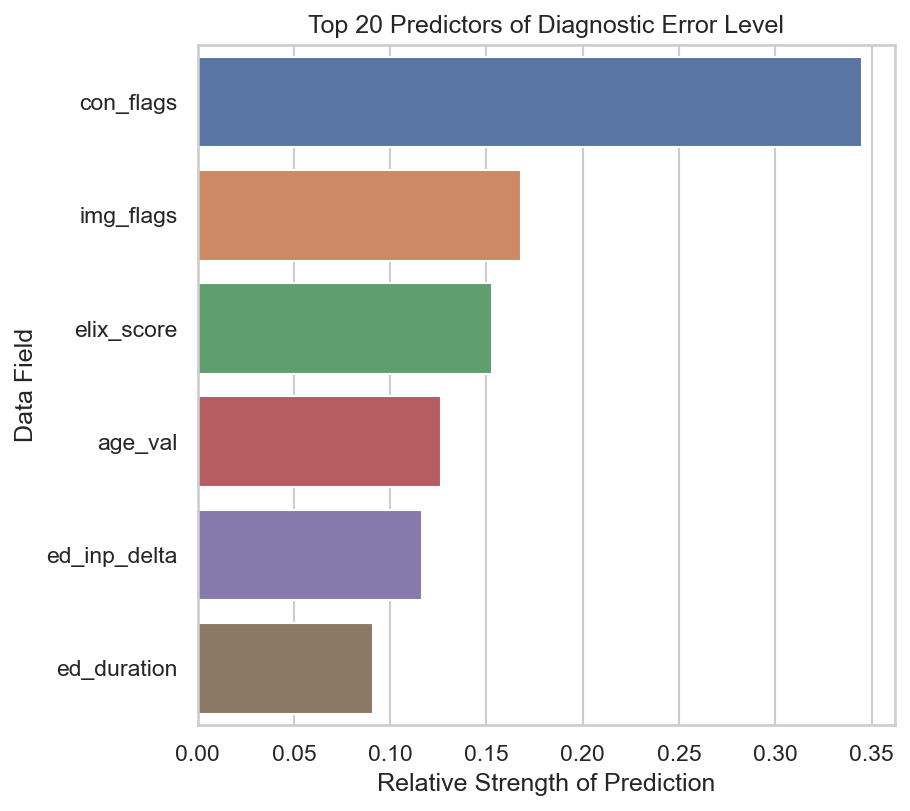

In [91]:
# create figure variables
xgb_importances_20_fig, xgb_importances_20_axes = plt.subplots()

temp_data = xgb_importances.head(20)['Feature Importance']
sns.barplot(y=temp_data.index, x=temp_data.values, ax=xgb_importances_20_axes)

# set text
xgb_importances_20_axes.set_title('Top 20 Predictors of Diagnostic Error Level')
xgb_importances_20_axes.set_ylabel('Data Field')
xgb_importances_20_axes.set_xlabel('Relative Strength of Prediction')

# save figure
xgb_importances_20_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['MAV'], 'predictor_strength_20_xgb.svg'))

In [ ]:
# split up data
#X_train, X_test, y_train, y_test = train_test_split(df[feature_columns], df[label_column], test_size=TEST_SIZE, random_state=RANDOM_STATE_SEED)

df[feature_columns], df[label_column]

In [ ]:
df[label_column]

In [94]:
clf = LogisticRegression(C=3, penalty='l2', solver='saga', max_iter=1000, fit_intercept=True)
clf.fit(df[feature_columns], df[label_column])
print(metrics.average_precision_score(df[label_column], clf.predict_proba(df[feature_columns])[:,1],pos_label='TTP'))

0.7372069473070625


In [95]:
df[label_column].value_counts()

TTP    124
TFP     93
Name: mod_label, dtype: int64

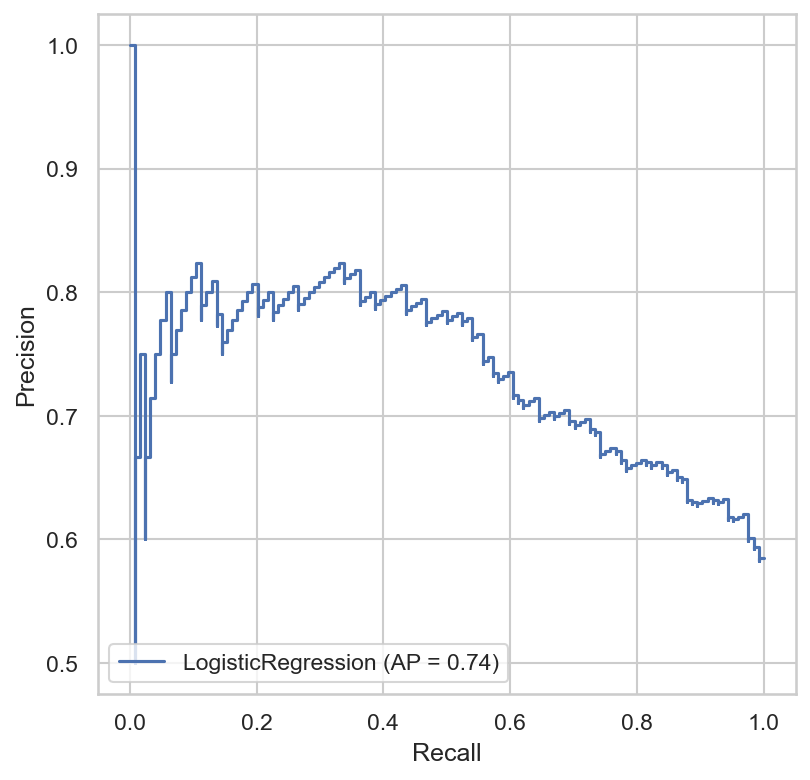

In [96]:
metrics.plot_precision_recall_curve(clf, df[feature_columns], df[label_column])

In [97]:
probs = clf.predict_proba(df[feature_columns])[:,1]
sortprobs = np.argsort(probs)
probs[sortprobs][:10]

array([0.17743141, 0.18185086, 0.19845815, 0.20379347, 0.20508259,
       0.20779318, 0.22674437, 0.22868596, 0.2415378 , 0.25034253])

In [98]:
df[label_column].iloc[sortprobs].iloc[-100:].value_counts()

TTP    73
TFP    27
Name: mod_label, dtype: int64

In [99]:
df[label_column].value_counts()

TTP    124
TFP     93
Name: mod_label, dtype: int64

In [100]:
from joblib import dump
dump(clf, 'saved_model_217samples_124pos_93neg.joblib')

['saved_model_217samples_124pos_93neg.joblib']

In [101]:
clf.coef_

array([[ 1.16349463, -0.29299042,  1.17074713, -1.22141065, -1.03069676,
         0.86681188]])

In [ ]:
df[feature_columns]

In [ ]:
df.head()

In [ ]:
df.tail()